## APMTH 207: Advanced Scientific Computing: Stochastic Methods for Data Analysis, Inference and Optimization
**Harvard University** <br>
**Fall 2018** <br>

### Paper Tutorial: Distilling the Knowledge in a Neural Network
- Authors: Geoffrey Hinton, Oriol Vinyals, Jeff Dean
- Link: https://arxiv.org/pdf/1503.02531.pdf

### Collaborators: Michelle (Chia Chi) Ho, Jiejun Lu, Jiawen Tong

---

# Executive Summary
<br>

**Problem Statement & Motivation**

The potential of deep neural net is increasingly realized in various industries, with which comes an increasing need to strategize model training in order to obtain powerful and deployable models. One strategy is to transfer the knowledge learned from a cumbersome but powerful (teacher) model to a smaller (student) model. Hinton et al. proposed an approach to knowledge transfer, which they coined "distillation", in "Distilling the Knowledge in a Neural Network". In this tutorial, we walk through the implementation and demonstrate the utility of knowledge distillation using the MNIST dataset and a fake dataset generated from the $\texttt{sklearn}$ library. 
<br>
<br>

**Experiments on Full MNIST Data**

For the MNIST dataset, we first trained a teacher network generally following the paper specifications, a neural net with 2 Dense layers, each with 1200 nodes. The teacher network made 168 errors on the test set. We then compared the performance of 3 different student networks, each composed of 2 hidden layers with 20 nodes: 1) Non-distilled student baseline, 2) Student distilled with soft targets at T=3 from the teacher; and 3) Student distilled with a weighted average bewteen soft target at T=3 and the cross-entropy loss of ground truth labels. The student networks made 368, 331 and 323 on the test set, respectively. We further trained a teacher network using a CNN model structure. The CNN teacher network showed significant improvement over the Dense teacher, making 97 errors on the test set. However, the student distilled from the CNN teacher performed only comparably to those distilled from the inferior Dense teacher net, making 340 errors.
<br>
<br>

**Experiments on Partial MNIST Data (omitting 3; only keeping 7 & 8)** 

Having demonstrated the general utility of distillation, we proceeded to distill student networks where the transfer dataset omits certain digits. The idea is that the distillation process should allow the student to learn digits it has never seen before as the knowledge is distailled from a teacher net that has seen all the digits. We first omitted digit 3 from the transfer set and found that our best performing distilled student net was able to get 56% of the test digit 3 samples correct while the non-distilled student net did not get any of these samples right. Additionaly, when only digits 7 and 8 are included in the transfer set, our best performing distilled student net and the non-distilled student net achieved 63% and 20% overall accuracy. Our results recapitulates the paper's findings. 
<br>
<br>

**Distillation Applied to Fake Datasets**

In the last part of this tutorial, we explored the relationship between data quality and the optimal distillation temperature. We used the $\texttt{make_classification}$ function from the $\texttt{sklearn}$ library to generate fake datasets with varying class separability and number of informative features. Data quality is presumed to be higher with higher class separability and higher number of informative features. At varying data quality, we compared the performance of a teacher, non-distilled student and students distilled at various temperatures. We found that, while distilled student nets showed superior model performance over non-distilled student nets in all cases, data quality did not affect the optimal distillation temperature ($T_{opt} \in (2.5, 5)$). Based on the results reported in the paper: A $T_{opt}$ at 20, 8 and 2.5-4 was found for student nets with 800, 300 and 30 nodes per hidden layer, respectively, we suspect that optimal distillation temperature may be more correlated with student net's architecture complexity, where $T_{opt}$ is higher for more complex structures. This hypothesis remains to be tested. 

---

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy as sp

import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Dropout, Lambda, Activation
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

import os
import itertools
import _pickle as cPickle
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

MAX_BYTES = 2**31 - 1

Using TensorFlow backend.


## Introduction

Training a powerful model that accurately extracts structure from data is often at odds with training a deployable model as the former objective tends to result in large and cumbersome models while the latter has much more stringent requirements on latency and computational resources. Thus, while the potential of deep neural net is increasingly realized in various industries, there is also increasing need to strategize model training in order to obtain powerful and deployable models. The general goal is to transfer the knowledge of a cumbersome but powerful (teacher) model to a smaller (student) model for deployment in real applications. To do so, the authors of this paper proposed the idea of "knowledge distillation". In this tutorial, we will go through the implementation for knowledge distillation and demonstrate its effectiveness.

## Distillation in the Math Form

In general, knowledge transfer is done by transforming the logits produced by the teacher model at some temperature to a set of “soft targets” for training the student model. The authors proposed the “distillation” approach: raising the temperature of the final softmax until the teacher model produces a suitably smoother set of targets and using the same high temperature when training the student model to learn from these soft targets. 

$$q_i=\dfrac{\exp(\frac{z_i}{T})}{\sum_j \exp(\frac{z_j}{T})}$$

The figure below visualizes the effect of raising temperature on the softmax layer: As temperature increases, the resulting class probability distribution "softens" (i.e. becomes flatter).

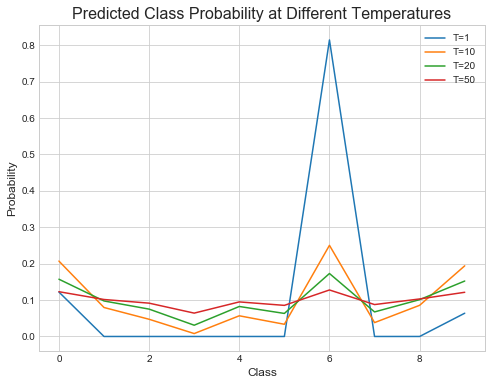

In [2]:
def softmax_temp(logit, temp):
    return np.exp(logit/temp) / np.exp(logit/temp).sum()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
p = np.random.rand(10) * 50
temps = [1, 10, 20, 50]
for t in temps:
    plt.plot(softmax_temp(p, t), label="T={}".format(t))
ax.set_title("Predicted Class Probability at Different Temperatures", fontsize=16)
ax.set_ylabel("Probability", fontsize=12)
ax.set_xlabel("Class", fontsize=12)
plt.legend();

## Experiments Part I on Full MNIST Data

In this part of the tutorial, we used the full MNIST dataset to train and compare:

- 2 teacher nets (a Dense 1200-1200-10 with heavy regularization and a CNN) 
- 4 student nets (Dense 20-20-10)
    - Baseline (non-distilled)
    - Distilled at T = 3, using cross-entropy loss with Dense teacher soft targets
    - Distilled at T = 3, using weighted average between cross-entropy loss with Dense teacher soft targets and cross-entropy loss with the true target label
    - Distilled at T = 3, using cross-entropy loss with CNN teacher

The main objective for this part of the tutorial is to demonstrate the general utility of distillation (i.e. distilled student nets are expected to perform better than the baseline (non-distilled) student net. 

Here, we load the MNIST data. There are 60000 and 10000 training and test samples, respectively.

In [2]:
# load mnist data & normalize to 0-1
# 1D data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype('float32')
x_test = x_test.reshape(-1, 28*28).astype('float32')
x_train /= 255.
x_test /= 255. 

# 2D data
(x_train_2D, _), (x_test_2D, _) = mnist.load_data()
x_train_2D = x_train_2D.reshape(x_train_2D.shape[0], 1, 28, 28).astype('float32')
x_test_2D = x_test_2D.reshape(x_test_2D.shape[0], 1, 28, 28).astype('float32')
x_train_2D /= 255.
x_test_2D /= 255.

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


### Training Teacher Nets
The two teacher nets we train are:

1. DENSE 1200-1200-10 with HEAVY REGULARIZATION
2. CNN

The first Dense teacher closely follows the specifications of the teacher net described in the paper. Since image data is typically handled using CNNs, we also trained the second CNN teacher. 

#### Dense Teacher Net

In [3]:
k_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
k_constraint = keras.constraints.MaxNorm(max_value=15, axis=0)

# Dense teacher model
mnist_dense = Sequential()
mnist_dense.add(Dense(1200, name='hidden_1', input_shape=(28*28, ), activation='relu', kernel_initializer=k_init, kernel_constraint=k_constraint))
mnist_dense.add(Dropout(0.7, name='dropout_1'))
mnist_dense.add(Dense(1200, name='hidden_2', activation='relu', kernel_initializer=k_init, kernel_constraint=k_constraint))
mnist_dense.add(Dropout(0.7, name='dropout_2'))
mnist_dense.add(Dense(10, name='logit'))
mnist_dense.add(Activation('softmax', name='softmax'))

mnist_dense.compile(loss=categorical_crossentropy, optimizer=Adam(0.0001), metrics=['accuracy'])

# fit model
mnist_dense.fit(x_train, y_train, batch_size=100, epochs=20, verbose=1, validation_data=(x_test, y_test))

loss, accuracy = mnist_dense.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('DENSE TECHERT NET - On test set:')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))

# save model
mnist_dense.save('./models/mnist_teacher_dense.h5')

In [5]:
# load model and print test performance
mnist_dense = load_model('./models/mnist_teacher_dense.h5')
loss, accuracy = mnist_dense.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('DENSE TECHERT NET - On test set:')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))

DENSE TECHERT NET - On test set:
loss = 0.055868843965092674, accuracy = 0.9832, #errors = 168


#### CNN Teacher net

In [5]:
# CNN teacher model
mnist_cnn = Sequential()

mnist_cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(1, 28, 28), name='conv_1'))
mnist_cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_2'))
mnist_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_1'))
mnist_cnn.add(Dropout(0.25, name='dropout_1'))

mnist_cnn.add(Flatten())
mnist_cnn.add(Dense(10, name='logit'))
mnist_cnn.add(Activation('softmax', name='softmax'))

mnist_cnn.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.0005), metrics=['accuracy'])

# fit model
mnist_cnn.fit(x_train_2D, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_test_2D, y_test))

# save model
mnist_cnn.save('./models/mnist_teacher_cnn.h5')

In [6]:
# load model and print test performance
mnist_cnn = load_model('./models/mnist_teacher_cnn.h5')
loss, accuracy = mnist_cnn.evaluate(x_test_2D, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('CNN TEACHER NET - On test set:')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))
print()

CNN TEACHER NET - On test set:
loss = 0.030440742732951186, accuracy = 0.9903, #errors = 97



### Student Net

All the student nets we trained share similar model architecture: 
- 2 dense layers, each with 20 hidden nodes
- the logit outputs before the original softmax transformation are normalized over a pre-specified temperature `T`
> - `T = 1` for hard targets
> - `T > 1` for distillation

This model architecture is defined below:

In [7]:
def MNIST_StudentNet(n_hidden, T):
    '''
    Function to build a studnet net
    '''
    model = Sequential()
    model.add(Dense(n_hidden, name='hidden_1', input_shape=(28*28, ), activation='relu'))
    model.add(Dense(n_hidden, name='hidden_2', activation='relu'))
    model.add(Dense(10, name='logit'))
    model.add(Lambda(lambda x: x / T, name='logit_soft'))
    model.add(Activation('softmax', name='softmax'))
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    return model

#### Training Student Net 1 - Baseline, No Distillation (T = 1)

In [8]:
# train baseline student net - NO distillation
mnist_student_basline = MNIST_StudentNet(n_hidden=20, T=1)
mnist_student_basline.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
mnist_student_basline.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_test))

# baseline student net model evaluation
loss, accuracy = mnist_student_basline.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('STUDENT BASELINE - On test set:')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.5879 - acc: 0.8240 - val_loss: 0.2767 - val_acc: 0.9236
Epoch 2/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.2539 - acc: 0.9275 - val_loss: 0.2207 - val_acc: 0.9364
Epoch 3/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.2081 - acc: 0.9404 - val_loss: 0.2061 - val_acc: 0.9383
Epoch 4/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.1822 - acc: 0.9475 - val_loss: 0.1834 - val_acc: 0.9473
Epoch 5/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.1647 - acc: 0.9527 - val_loss: 0.1707 - val_acc: 0.9512
Epoch 6/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1513 - acc: 0.9568 - val_loss: 0.1581 - val_acc: 0.9537
Epoch 7/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1416 - acc: 0.9590 - val_loss: 0.1510 - val_acc

#### Training Student Net 2 - distilling from Dense teacher at T = 3

In [8]:
def get_layer_output(model, layer_name):
    output = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return output

# compute 'soft target'
T = 3
teacher_logit = get_layer_output(mnist_dense, 'logit')
logit_train = teacher_logit.predict(x_train)
y_train_soft = K.softmax(logit_train / T).eval(session=K.get_session())

# train student net distilled from the dense teacher net
mnist_student_distilled = MNIST_StudentNet(n_hidden=20, T=T)
mnist_student_distilled.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
mnist_student_distilled.fit(x_train, y_train_soft, 
                            batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_test))

# distilled student net model evaluation
loss, accuracy = mnist_student_distilled.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('DISTILLED STUDENT - On test set:')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 29us/step - loss: 1.0716 - acc: 0.7981 - val_loss: 0.4087 - val_acc: 0.9109
Epoch 2/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.7406 - acc: 0.9192 - val_loss: 0.3516 - val_acc: 0.9244
Epoch 3/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.6985 - acc: 0.9355 - val_loss: 0.3108 - val_acc: 0.9385
Epoch 4/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.6782 - acc: 0.9445 - val_loss: 0.2938 - val_acc: 0.9424
Epoch 5/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.6675 - acc: 0.9500 - val_loss: 0.2873 - val_acc: 0.9466
Epoch 6/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.6602 - acc: 0.9539 - val_loss: 0.2771 - val_acc: 0.9499
Epoch 7/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.6537 - acc: 0.9577 - val_loss: 0.2674 - val_acc

#### Training Student Net 3 - Distilling from weighted loss of both the soft target and the true labels' cross-entropy at T = 3

In [14]:
def avg_mix_loss(y_true, y_pred, w, T):    
    # split hard & soft targets
    y_hard, y_soft = y_true[:, :10], y_true[:, 10:]
    
    # convert logits to predicted values
    y_hard_pred = K.softmax(y_pred) # hard target
    y_soft_pred = K.softmax(y_pred / T) # soft target
    
    # compute weighted avg of the 2 parts of losses
    avg_loss = w * categorical_crossentropy(y_hard, y_hard_pred) + categorical_crossentropy(y_soft, y_soft_pred)
    
    return avg_loss

In [15]:
n_hidden = 20
T = 3
w = 0.7 / (T**2)

# apply both hard & soft targets to learn
logit_test = teacher_logit.predict(x_test)
y_test_soft = K.softmax(logit_test / T).eval(session=K.get_session())
y_hard_soft_train = np.concatenate((y_train, y_train_soft), axis=1)
y_hard_soft_test = np.concatenate((y_test, y_test_soft), axis=1)

# fit the student net distilled from the dense teacher net with the hard-soft weighted avg loss
mnist_student_mix = Sequential()
mnist_student_mix.add(Dense(n_hidden, name='hidden_1', input_shape=(28*28, ), activation='relu'))
mnist_student_mix.add(Dense(n_hidden, name='hidden_2', activation='relu'))
mnist_student_mix.add(Dense(10, name='logit'))

# y_pred at the end of 10-node dense layer is the logit_pred
mnist_student_mix.compile(loss=lambda y_true, y_pred: avg_mix_loss(y_true, y_pred, w, T), 
                          optimizer=Adam(), metrics=['accuracy'])

mnist_student_mix.fit(x_train, y_hard_soft_train, 
                      batch_size=100, epochs=50, verbose=1, validation_data=(x_test, y_hard_soft_test))


# distilled student net with mix-hard-soft loss model evaluation
loss, accuracy = mnist_student_mix.evaluate(x_test, y_hard_soft_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('DISTILLED STUDENT with WEIGHTED HARD/SOFT TARGET - On test set:')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 44us/step - loss: 1.0612 - acc: 0.8294 - val_loss: 0.7709 - val_acc: 0.9172
Epoch 2/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.7508 - acc: 0.9234 - val_loss: 0.7099 - val_acc: 0.9344
Epoch 3/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.7103 - acc: 0.9362 - val_loss: 0.6848 - val_acc: 0.9429
Epoch 4/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.6903 - acc: 0.9442 - val_loss: 0.6726 - val_acc: 0.9472
Epoch 5/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.6769 - acc: 0.9497 - val_loss: 0.6657 - val_acc: 0.9481
Epoch 6/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.6675 - acc: 0.9533 - val_loss: 0.6559 - val_acc: 0.9543
Epoch 7/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.6604 - acc: 0.9565 - val_loss: 0.6514 - val_acc

#### Training Student Net 4 - Distilling from CNN teacher at T = 3

In [17]:
# compute 'soft target' of the CNN teacher net
T = 3
teacher_logit_cnn = get_layer_output(mnist_cnn, 'logit')
logit_train_cnn = teacher_logit_cnn.predict(x_train_2D)
y_train_soft_cnn = K.softmax(logit_train_cnn / T).eval(session=K.get_session())

# train student net distilled from the CNN teacher net
mnist_student_distilled_cnn = MNIST_StudentNet(n_hidden=20, T=T)
mnist_student_distilled_cnn.fit(x_train, y_train_soft_cnn, 
                                batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_test))

# student net model evalutation
loss, accuracy = mnist_student_distilled_cnn.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('DISTILLED STUDENT from CNN TEACHER - On test set:')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.9567 - acc: 0.7943 - val_loss: 0.3894 - val_acc: 0.9022
Epoch 2/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.6094 - acc: 0.9093 - val_loss: 0.3409 - val_acc: 0.9193
Epoch 3/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.5729 - acc: 0.9221 - val_loss: 0.3056 - val_acc: 0.9297
Epoch 4/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.5469 - acc: 0.9314 - val_loss: 0.2815 - val_acc: 0.9345
Epoch 5/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.5277 - acc: 0.9388 - val_loss: 0.2654 - val_acc: 0.9405
Epoch 6/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.5138 - acc: 0.9443 - val_loss: 0.2596 - val_acc: 0.9394
Epoch 7/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.5043 - acc: 0.9469 - val_loss: 0.2498 - val_acc

#### Summary of student net performances

In [3]:
student_summary = {
    'baseline': {'loss': 0.15354005151256278, 'accuracy': 0.9632, 'num_error': 368},
    'dense_distilled': {'loss': 0.22846840821504594, 'accuracy':  0.9669, 'num_error': 331},
    'dense_distilled_mix_loss': {'loss': 0.6234446800231933, 'accuracy': 0.9676, 'num_error': 323},
    'cnn_distilled': {'loss': 0.1805808451652527, 'accuracy': 0.966, 'num_error': 340}
}

print('=== Student Net Performance on Full Test Set ===')
df_student_summary = pd.DataFrame().from_dict(student_summary).T
display(df_student_summary)

=== Student Net Performance on Full Test Set ===


,accuracy,loss,num_error
baseline,0.9632,0.153540,368.0
cnn_distilled,0.9660,0.180581,340.0
dense_distilled,0.9669,0.228468,331.0
dense_distilled_mix_loss,0.9676,0.623445,323.0


### Conclusions - Experiments on Full MNIST Data

In the paper, the digits were first jittered by up to two pixels in any direction to make the classification task more difficult so that the teacher and the student would show observable differences in their learning capacities. Without jittering the digits in our implementation, we found that a student net with relatively complex structure (E.g., 800-800-10) can learn from the ground truth labels very well without distillation. Therefore, to better show the effect of distillation, we chose a much simpler student net structure: 20-20-10. 

For the teacher net, we trained a CNN model in addition to the Dense model (1200-1200-10) reported in the paper because CNN structure is the conventional and more effective method to handle image data. Indeed, we found that the Dense and CNN teacher net achieved a test accuracy = 0.9832 (168 errors) and 0.9903 (97 errors), respectively. While non-distilled student baseline achieved an accuracy = 0.9632 (368 errors), learning from the Dense and the CNN teacher at T=3, the distilled students achieved an accuracy = 0.9669 (331 errors) and 0.9660 (340 errors), respectively. This demonstrates that 1) distillation improves student model performance; and 2) Distilling from a superior model (CNN teacher) does not necessarily translate into superior student model performance. By learning from both the ground truth label and the Dense teacher (with the ground truth weighted more heavily at a weight = 0.7), the performance of the distilled student further improved to a test accuracy = 0.9676 (323 errors).

---

## Experiment Part II-a on Partial MNIST Data -- omitting digit 3 in the transfer set

As above, we’ve shown that the distilled student net performs better than one without distillation. In the following, our experiments showed that the distilled student can even learn from a transfer set without all of the digits, 0-9. When omitting or keeping certain digits from the transfer set, a non-distilled student net cannot generalize and is unable to understand digits it has never seen. However, distillation presumably enables the student to learn from the teacher's knowledge on how to distinguish all of the digits with the teacher's soft target. The amount of information from the teacher's soft target is controlled by the temperature parameter.

In HW7, we built an MLP model on MNIST. We found that on the training set, digit 3 is one of the most easily misclassified label as it is similar with digit 5, 8 and 2. A well trained teacher net on the full training data is expected to have captured the characteristics of digit 3 and its relative similarity with other labels. In the following experiment, we omitted all examples of digit 3 from the transfer set and trained three student nets: 1) non-distilled baseline, 2) distilled at T = 3, and 3) distilled at T = 3 with a mixture of ground truth and teacher soft target losses. 

<img src="mis_hist.png">

Here, we provide code to omit the digit 3 from the training dataset.

In [10]:
idx = (y_train[:,3] == 1)
x_train_omit3 = x_train[~idx,:]
y_train_omit3 = y_train[~idx,:]
y_train_soft_omit3 = y_train_soft[~idx,:]

#### Training Student Net 1 - Baseline, No Distillation (T = 1)

In [11]:
# student net - NO distillation - digit 3 omitted in the transfer set
hard_omit3 = MNIST_StudentNet(n_hidden=20, T=1)
hard_omit3.fit(x_train_omit3, y_train_omit3, 
               batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_test))

Train on 53869 samples, validate on 10000 samples
Epoch 1/50
53869/53869 [==============================] - 1s 27us/step - loss: 0.5718 - acc: 0.8305 - val_loss: 1.4462 - val_acc: 0.8312
Epoch 2/50
53869/53869 [==============================] - 1s 20us/step - loss: 0.2327 - acc: 0.9334 - val_loss: 1.5448 - val_acc: 0.8428
Epoch 3/50
53869/53869 [==============================] - 1s 20us/step - loss: 0.1900 - acc: 0.9450 - val_loss: 1.5695 - val_acc: 0.8502
Epoch 4/50
53869/53869 [==============================] - 1s 19us/step - loss: 0.1638 - acc: 0.9522 - val_loss: 1.5985 - val_acc: 0.8567
Epoch 5/50
53869/53869 [==============================] - 1s 20us/step - loss: 0.1444 - acc: 0.9577 - val_loss: 1.5859 - val_acc: 0.8601
Epoch 6/50
53869/53869 [==============================] - 1s 19us/step - loss: 0.1322 - acc: 0.9611 - val_loss: 1.6107 - val_acc: 0.8616
Epoch 7/50
53869/53869 [==============================] - 1s 19us/step - loss: 0.1217 - acc: 0.9641 - val_loss: 1.6145 - val_acc

#### Training Student Net 2 - distilling from Dense teacher at T = 3

In [12]:
# student net - WITH distillation - digit 3 omitted in the transfer set
soft_omit3 = MNIST_StudentNet(n_hidden=20, T=3)
soft_omit3.fit(x_train_omit3, y_train_soft_omit3, 
               batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_test))

Train on 53869 samples, validate on 10000 samples
Epoch 1/50
53869/53869 [==============================] - 1s 25us/step - loss: 1.0962 - acc: 0.7889 - val_loss: 0.6145 - val_acc: 0.8243
Epoch 2/50
53869/53869 [==============================] - 1s 24us/step - loss: 0.7442 - acc: 0.9269 - val_loss: 0.5496 - val_acc: 0.8405
Epoch 3/50
53869/53869 [==============================] - 1s 19us/step - loss: 0.7057 - acc: 0.9430 - val_loss: 0.4999 - val_acc: 0.8513
Epoch 4/50
53869/53869 [==============================] - 1s 19us/step - loss: 0.6878 - acc: 0.9499 - val_loss: 0.4911 - val_acc: 0.8571
Epoch 5/50
53869/53869 [==============================] - 1s 19us/step - loss: 0.6771 - acc: 0.9551 - val_loss: 0.4655 - val_acc: 0.8616
Epoch 6/50
53869/53869 [==============================] - 1s 19us/step - loss: 0.6704 - acc: 0.9578 - val_loss: 0.4524 - val_acc: 0.8645
Epoch 7/50
53869/53869 [==============================] - 1s 19us/step - loss: 0.6653 - acc: 0.9606 - val_loss: 0.4447 - val_acc

#### Training Student Net 3 - Distilling from the weighted loss of both the soft target and the true labels' cross-entropy at T = 5

In [25]:
n_hidden = 20
T = 5
w = 0.4 / (T**2) 

# apply both hard & soft targets to learn
y_hard_soft_train_omit3 = np.concatenate((y_train_omit3, y_train_soft_omit3), axis=1)

# student net - WITH distillation & weighted hard soft loss - digit 3 omitted in the transfer set
mix_omit3 = Sequential()
mix_omit3.add(Dense(n_hidden, name='hidden_1', input_shape=(28*28, ), activation='relu'))
mix_omit3.add(Dense(n_hidden, name='hidden_2', activation='relu'))
mix_omit3.add(Dense(10, name='logit'))

# y_pred at the end of 10-node dense layer is the logit_pred
mix_omit3.compile(loss=lambda y_true, y_pred: avg_mix_loss(y_true, y_pred, w, T), 
                  optimizer=Adam(), metrics=['accuracy'])

mix_omit3.fit(x_train_omit3, y_hard_soft_train_omit3, 
              batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_hard_soft_test))


Train on 53869 samples, validate on 10000 samples
Epoch 1/50
53869/53869 [==============================] - 2s 35us/step - loss: 1.1521 - acc: 0.7983 - val_loss: 1.8253 - val_acc: 0.8206
Epoch 2/50
53869/53869 [==============================] - 1s 22us/step - loss: 0.7695 - acc: 0.9210 - val_loss: 1.7625 - val_acc: 0.8422
Epoch 3/50
53869/53869 [==============================] - 1s 24us/step - loss: 0.7313 - acc: 0.9334 - val_loss: 1.7412 - val_acc: 0.8504
Epoch 4/50
53869/53869 [==============================] - 1s 24us/step - loss: 0.7094 - acc: 0.9420 - val_loss: 1.7284 - val_acc: 0.8591
Epoch 5/50
53869/53869 [==============================] - 1s 22us/step - loss: 0.6928 - acc: 0.9492 - val_loss: 1.7250 - val_acc: 0.8649
Epoch 6/50
53869/53869 [==============================] - 1s 23us/step - loss: 0.6775 - acc: 0.9551 - val_loss: 1.7105 - val_acc: 0.8715
Epoch 7/50
53869/53869 [==============================] - 1s 25us/step - loss: 0.6686 - acc: 0.9590 - val_loss: 1.7007 - val_acc

#### Evaluations of these student nets on the Test set 

In [26]:
print('=== Overall Accuracy on Test set === \n')

loss, accuracy = hard_omit3.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('NO DISTILLATION')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))
print()

print('WITH DISTILLATION')
loss, accuracy = soft_omit3.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))
print()

print('WITH DISTILLATION & WEIGHTED HARD-SOFT TARGET')
loss, accuracy = mix_omit3.evaluate(x_test, y_hard_soft_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))


=== Overall Accuracy on Test set === 

NO DISTILLATION
loss = 1.7654574642470455, accuracy = 0.8672, #errors = 1328

WITH DISTILLATION
loss = 0.3250568591117859, accuracy = 0.9209, #errors = 790

WITH DISTILLATION & WEIGHTED HARD-SOFT TARGET
loss = 1.62039946975708, accuracy = 0.9251, #errors = 748


In [27]:
print('=== Digit-3 Only Accuracy on Test set === \n')

idx2 = y_test[:,3] == 1
x_test_3 = x_test[idx2, :]
y_test_3 = y_test[idx2, :]
y_test_soft_3 = y_test[idx2,:]
y_hard_soft_test_3 = np.concatenate((y_test_3, y_test_soft_3), axis=1)

loss, accuracy = hard_omit3.evaluate(x_test_3, y_test_3, verbose=0)
num_errors = int((1 - accuracy) * len(x_test_3))
print('NO DISTILLATION')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))
print()

loss, accuracy = soft_omit3.evaluate(x_test_3, y_test_3, verbose=0)
num_errors = int((1 - accuracy) * len(x_test_3))
print('WITH DISTILLATION')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))
print()

loss, accuracy = mix_omit3.evaluate(x_test_3, y_hard_soft_test_3, verbose=0)
num_errors = int((1 - accuracy) * len(x_test_3))
print('WITH DISTILLATION & WEIGHTED HARD-SOFT TARGET')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))


=== Digit-3 Only Accuracy on Test set === 

NO DISTILLATION
loss = 16.11809539794922, accuracy = 0.0, #errors = 1010

WITH DISTILLATION
loss = 1.238349964595077, accuracy = 0.4811881188708957, #errors = 523

WITH DISTILLATION & WEIGHTED HARD-SOFT TARGET
loss = 1.2482987630485307, accuracy = 0.5217821782473291, #errors = 482


#### Tuning Bias
The paper also claimed that better performance can be acheived by tuning the bias term during distillation, so here we show the implementation of tuning the bias to optimize test performance.

In [33]:
# tune bias
soft_omit3_bias = MNIST_StudentNet(n_hidden=20, T=3)
bias = soft_omit3_bias.layers[2].get_weights()[1]
bias[3] = 3.5
K.set_value(soft_omit3_bias.layers[2].bias, bias)

soft_omit3_bias.fit(x_train_omit3, y_train_soft_omit3, 
                    batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_test))

Train on 53869 samples, validate on 10000 samples
Epoch 1/50
53869/53869 [==============================] - 2s 37us/step - loss: 1.0913 - acc: 0.7864 - val_loss: 0.6302 - val_acc: 0.8288
Epoch 2/50
53869/53869 [==============================] - 1s 23us/step - loss: 0.7331 - acc: 0.9324 - val_loss: 0.5332 - val_acc: 0.8457
Epoch 3/50
53869/53869 [==============================] - 2s 28us/step - loss: 0.6994 - acc: 0.9460 - val_loss: 0.4937 - val_acc: 0.8550
Epoch 4/50
53869/53869 [==============================] - 1s 25us/step - loss: 0.6826 - acc: 0.9532 - val_loss: 0.4508 - val_acc: 0.8640
Epoch 5/50
53869/53869 [==============================] - 1s 25us/step - loss: 0.6719 - acc: 0.9577 - val_loss: 0.4296 - val_acc: 0.8719
Epoch 6/50
53869/53869 [==============================] - 1s 27us/step - loss: 0.6637 - acc: 0.9625 - val_loss: 0.4201 - val_acc: 0.8765
Epoch 7/50
53869/53869 [==============================] - 1s 25us/step - loss: 0.6577 - acc: 0.9650 - val_loss: 0.4011 - val_acc

In [34]:
print('=== BIAS TUNED - Overall Accuracy on Test set === \n')
loss, accuracy = soft_omit3_bias.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))
print()

print('=== BIAS TUNED - Digit-3 Only Accuracy on Test set === \n')
loss, accuracy = soft_omit3_bias.evaluate(x_test_3, y_test_3, verbose=0)
num_errors = int((1 - accuracy) * len(x_test_3))
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))


=== BIAS TUNED - Overall Accuracy on Test set === 

loss = 0.312171789765358, accuracy = 0.9293, #errors = 706

=== BIAS TUNED - Digit-3 Only Accuracy on Test set === 

loss = 1.102321712805493, accuracy = 0.5613861386728759, #errors = 442


#### Summary of model performance 

In [4]:
omit3_summary_overall = {
    'baseline': {'loss': 1.7654574642470455, 'accuracy': 0.8672, 'num_error': 1328},
    'dense_distilled': {'loss': 0.3250568591117859, 'accuracy': 0.9209, 'num_error': 790},
    'dense_distilled_mix_loss': {'loss': 1.62039946975708, 'accuracy': 0.9251, 'num_error': 748},
    'bias_tuned': {'loss': 0.312171789765358, 'accuracy': 0.9293, 'num_error': 706}
}
omit3_summary_3only = {
    'baseline': {'loss': 16.11809539794922, 'accuracy': 0.0, 'num_error': 1010},
    'dense_distilled': {'loss': 1.238349964595077, 'accuracy': 0.4811881188708957, 'num_error': 523},
    'dense_distilled_mix_loss': {'loss': 1.2482987630485307, 'accuracy': 0.5217821782473291, 'num_error': 482},
    'bias_tuned': {'loss': 1.102321712805493, 'accuracy': 0.5613861386728759, 'num_error': 442}
}

df_omit3_summary_overall = pd.DataFrame().from_dict(omit3_summary_overall).T
df_omit3_summary_3only = pd.DataFrame().from_dict(omit3_summary_3only).T

print('=== Omit3 Distillation Performance on Full Test Set ===')
display(df_omit3_summary_overall)
print()

print('=== Omit3 Distillation Performance on Digit 3 Test Samples ===')
display(df_omit3_summary_3only)
print()

=== Omit3 Distillation Performance on Full Test Set ===


,accuracy,loss,num_error
baseline,0.8672,1.765457,1328.0
bias_tuned,0.9293,0.312172,706.0
dense_distilled,0.9209,0.325057,790.0
dense_distilled_mix_loss,0.9251,1.620399,748.0



=== Omit3 Distillation Performance on Digit 3 Test Samples ===


,accuracy,loss,num_error
baseline,0.000000,16.118095,1010.0
bias_tuned,0.561386,1.102322,442.0
dense_distilled,0.481188,1.238350,523.0
dense_distilled_mix_loss,0.521782,1.248299,482.0


### Conclusions - distillation performance of student nets trained on data sets without digit 3

Comparing the accuracy on the full test data and on the digit 3 only subset, we observed the worst performance from the non-distilled student baseline test accuracy = 86.8% overall and 0% on 3-only set. With distillation, the student net showed an improved accuracy = 92.1% on full test set and 48.1% on 3-only set. According to the paper, most of the errors are caused by an inappropriate bias for class 3. After adjusting this bias to 3.5 (which optimizes overall accuracy), the distilled model further increased its accuracy to 92.9% and 56.1% on 3-only set.

---

## Experiment Part II-b on Partial MNIST Data -- keeping only digit 7 and 8 in the transfer set

Based on the misclassification distributions of all digits HW7, 7 and 8 with the digits that they are mostly likely being misclassified as cover all class labels. In the following, we kept only digit 7 & 8 in the transfer set and showed results of distillation on 3 student nets: 1) a non-distilled baseline, 2) a distilled student with tuned bias and 3) a distilled student with a mixture of hard and soft losses.

Here, we provide code to keep only the digits 7 and 8 from the training dataset.

In [38]:
# keep 7 and 8 in transfer set
idx78 = [True if y[7]==1 or y[8] == 1 else False for y in y_train]

x_train_78 = x_train[idx78,:]
y_train_soft_78 = y_train_soft[idx78,:]
y_train_78 = y_train[idx78,:]

#### Training Student Net 1 - Baseline, No Distillation

In [39]:
# train hard target model with training set omitting digit 3
hard_78 = MNIST_StudentNet(n_hidden=20, T=1)
hard_78.fit(x_train_78, y_train_78, batch_size=128, epochs=50, verbose=1, validation_data=(x_test, y_test))

Train on 12116 samples, validate on 10000 samples
Epoch 1/50
12116/12116 [==============================] - 2s 161us/step - loss: 0.3170 - acc: 0.9272 - val_loss: 8.2521 - val_acc: 0.1965
Epoch 2/50
12116/12116 [==============================] - 1s 58us/step - loss: 0.0342 - acc: 0.9889 - val_loss: 9.1068 - val_acc: 0.1973
Epoch 3/50
12116/12116 [==============================] - 1s 51us/step - loss: 0.0259 - acc: 0.9919 - val_loss: 9.5551 - val_acc: 0.1976
Epoch 4/50
12116/12116 [==============================] - 1s 48us/step - loss: 0.0220 - acc: 0.9931 - val_loss: 9.8298 - val_acc: 0.1974
Epoch 5/50
12116/12116 [==============================] - 1s 51us/step - loss: 0.0201 - acc: 0.9931 - val_loss: 10.0648 - val_acc: 0.1980
Epoch 6/50
12116/12116 [==============================] - 1s 53us/step - loss: 0.0183 - acc: 0.9941 - val_loss: 10.2347 - val_acc: 0.1979
Epoch 7/50
12116/12116 [==============================] - 1s 99us/step - loss: 0.0177 - acc: 0.9938 - val_loss: 10.3479 - val

#### Training Student Net 2 - distilling from Dense teacher at T = 3

In [40]:
# train soft target model with training set omitting digit 3
soft_78 = MNIST_StudentNet(n_hidden=20, T=3)
soft_78.fit(x_train_78, y_train_soft_78, batch_size=128, epochs=100, verbose=1, validation_data=(x_test, y_test))

Train on 12116 samples, validate on 10000 samples
Epoch 1/100
12116/12116 [==============================] - 2s 166us/step - loss: 1.3137 - acc: 0.8350 - val_loss: 2.7221 - val_acc: 0.1943
Epoch 2/100
12116/12116 [==============================] - 1s 67us/step - loss: 0.8349 - acc: 0.9833 - val_loss: 2.3942 - val_acc: 0.1964
Epoch 3/100
12116/12116 [==============================] - 1s 92us/step - loss: 0.7921 - acc: 0.9874 - val_loss: 2.2301 - val_acc: 0.1971
Epoch 4/100
12116/12116 [==============================] - 0s 40us/step - loss: 0.7810 - acc: 0.9888 - val_loss: 2.1232 - val_acc: 0.1986
Epoch 5/100
12116/12116 [==============================] - 0s 41us/step - loss: 0.7738 - acc: 0.9893 - val_loss: 2.0344 - val_acc: 0.2018
Epoch 6/100
12116/12116 [==============================] - 0s 40us/step - loss: 0.7676 - acc: 0.9901 - val_loss: 1.9403 - val_acc: 0.2127
Epoch 7/100
12116/12116 [==============================] - 0s 39us/step - loss: 0.7628 - acc: 0.9902 - val_loss: 1.8744 -

#### Training Student Net 3 - Distilling from weighted loss of both the soft target and the true labels' cross-entropy at T = 5

In [43]:
n_hidden = 20
T = 5
w = 0.5 / (T**2) 

# apply both hard & soft targets to learn
y_hard_soft_train_78 = np.concatenate((y_train_78, y_train_soft_78), axis=1)

# student net - WITH distillation & weighted hard soft loss - digit 3 omitted in the transfer set
mix_78 = Sequential()
mix_78.add(Dense(n_hidden, name='hidden_1', input_shape=(28*28, ), activation='relu'))
mix_78.add(Dense(n_hidden, name='hidden_2', activation='relu'))
mix_78.add(Dense(10, name='logit'))

# y_pred at the end of 10-node dense layer is the logit_pred
mix_78.compile(loss=lambda y_true, y_pred: avg_mix_loss(y_true, y_pred, w, T), 
               optimizer=Adam(), metrics=['accuracy'])

mix_78.fit(x_train_78, y_hard_soft_train_78, 
           batch_size=128, epochs=100, verbose=1, validation_data=(x_test, y_hard_soft_test))


Train on 12116 samples, validate on 10000 samples
Epoch 1/100
12116/12116 [==============================] - 4s 314us/step - loss: 1.4717 - acc: 0.8966 - val_loss: 3.1774 - val_acc: 0.1925
Epoch 2/100
12116/12116 [==============================] - 1s 110us/step - loss: 0.8514 - acc: 0.9808 - val_loss: 2.7144 - val_acc: 0.1955
Epoch 3/100
12116/12116 [==============================] - 1s 82us/step - loss: 0.8034 - acc: 0.9891 - val_loss: 2.5803 - val_acc: 0.1967
Epoch 4/100
12116/12116 [==============================] - 1s 81us/step - loss: 0.7909 - acc: 0.9908 - val_loss: 2.5080 - val_acc: 0.1974
Epoch 5/100
12116/12116 [==============================] - 1s 75us/step - loss: 0.7839 - acc: 0.9916 - val_loss: 2.4242 - val_acc: 0.1986
Epoch 6/100
12116/12116 [==============================] - 1s 67us/step - loss: 0.7786 - acc: 0.9922 - val_loss: 2.4065 - val_acc: 0.2003
Epoch 7/100
12116/12116 [==============================] - 1s 66us/step - loss: 0.7741 - acc: 0.9929 - val_loss: 2.3520 

#### Tuning Bias
Similar to experiments on omitting 3's, we can also tune the bias in this case.

In [44]:
soft_78_bias = MNIST_StudentNet(n_hidden=20, T=3)
bias = soft_78_bias.layers[2].get_weights()[1]
bias[7] = 1
bias[8] = 1
K.set_value(soft_78_bias.layers[2].bias, bias)

soft_78_bias.fit(x_train_78, y_train_soft_78, 
                 batch_size=128, epochs=100,verbose=1, validation_data=(x_test, y_test))

Train on 12116 samples, validate on 10000 samples
Epoch 1/100
12116/12116 [==============================] - 2s 158us/step - loss: 1.1857 - acc: 0.9439 - val_loss: 2.7235 - val_acc: 0.1951
Epoch 2/100
12116/12116 [==============================] - 1s 49us/step - loss: 0.8168 - acc: 0.9835 - val_loss: 2.4055 - val_acc: 0.1966
Epoch 3/100
12116/12116 [==============================] - 0s 40us/step - loss: 0.7902 - acc: 0.9879 - val_loss: 2.2500 - val_acc: 0.1972
Epoch 4/100
12116/12116 [==============================] - 1s 42us/step - loss: 0.7781 - acc: 0.9889 - val_loss: 2.1407 - val_acc: 0.1979
Epoch 5/100
12116/12116 [==============================] - 1s 43us/step - loss: 0.7688 - acc: 0.9896 - val_loss: 1.9956 - val_acc: 0.1990
Epoch 6/100
12116/12116 [==============================] - 1s 45us/step - loss: 0.7621 - acc: 0.9907 - val_loss: 1.9205 - val_acc: 0.2064
Epoch 7/100
12116/12116 [==============================] - 1s 49us/step - loss: 0.7574 - acc: 0.9910 - val_loss: 1.8677 -

#### Summary of model performance

In [48]:
print('=== Overall Accuracy on Test set === \n')

loss, accuracy = hard_78.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('NO DISTILLATION')
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))
print()

print('WITH DISTILLATION')
loss, accuracy = soft_78.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))
print()

print('WITH DISTILLATION & WEIGHTED HARD-SOFT TARGET')
loss, accuracy = mix_78.evaluate(x_test, y_hard_soft_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))
print()

print('WITH DISTILLATION & BIAS TUNED')
loss, accuracy = soft_78_bias.evaluate(x_test, y_test, verbose=0)
num_errors = int((1 - accuracy) * len(x_test))
print('loss = {}, accuracy = {}, #errors = {}'.format(loss, accuracy, num_errors))


=== Overall Accuracy on Test set === 

NO DISTILLATION
loss = 11.931765022277832, accuracy = 0.1986, #errors = 8014

WITH DISTILLATION
loss = 1.07515452003479, accuracy = 0.6182, #errors = 3818

WITH DISTILLATION & WEIGHTED HARD-SOFT TARGET
loss = 1.2918906003952026, accuracy = 0.6241, #errors = 3759

WITH DISTILLATION & BIAS TUNED
loss = 1.050957187271118, accuracy = 0.6302, #errors = 3698


In [5]:
keep78_summary = {
    'baseline': {'loss': 11.931765022277832, 'accuracy': 0.1986, 'num_error': 8014},
    'dense_distilled': {'loss': 1.07515452003479, 'accuracy': 0.6182, 'num_error': 3818},
    'dense_distilled_mix_loss': {'loss': 1.2918906003952026, 'accuracy': 0.6241, 'num_error': 3759},
    'bias_tuned': {'loss': 1.050957187271118, 'accuracy': 0.6302, 'num_error': 3698}
}

print('=== Only 7 & 8 Distillation Performance on Full Test Set ===')
df_keep78_summary = pd.DataFrame().from_dict(keep78_summary).T
display(df_keep78_summary)

=== Only 7 & 8 Distillation Performance on Full Test Set ===


,accuracy,loss,num_error
baseline,0.1986,11.931765,8014.0
bias_tuned,0.6302,1.050957,3698.0
dense_distilled,0.6182,1.075155,3818.0
dense_distilled_mix_loss,0.6241,1.291891,3759.0


### Conclusion - distillation performances of student nets on transfer sets of digit 7 & 8 only

The non-distilled student baseline achieved the worst accuracy = 19.9%. All other distilled models performed stunningly better, with accuracies over 61%.

---

## Experiments Part III - Distillation Applied to Fake Datasets

As shown in the first figure of this tutorial, increasing temperature leads to increasing target "softness". Therefore, we hypothesized that datasets with different data quality (i.e. degree of class separability and the number of informative features) may require different temperature for optimal distillation outcome. In the following experiment, we used the $\texttt{sklearn}$ library to synthesize 9 datasets with varying degrees of data quality. Specifically, the datasets were synthesized using the follwoing parameters: $n\_samples$ = 50000, $n\_features$ = 100, $n\_classes$ = 10, $n\_clusters\_per\_class$ = 1. In addition, data quailty was synthesized using $class\_sep \in (0.2, 0.6, 1)$ and $p\_informative \in (0.5, 0.8, 1)$ where $n\_informative$ = $p\_informative$ x $n\_features$. The teacher net has 3 hidden layers, each with 100 nodes; the student net has 2 hidden layers, each with 50 nodes. Distillation was done at $T \in (2, 2.5, 3, 4, 5, 10, 15, 20)$. Both teacher and students were trained for 50 epochs.

Here, we define the FakeDataGenerator class to generate fake data with the option to vary data quality (as defined by the number of informative features and class separation) and the structures of the teacher/student net. The FakeTeacherNet has 3 Dense layers, each with 100 nodes and interspersed with a Dropout of 0.2. The FakeStudentNet has 2 Dense layers, each with 50 nodes.  

In [37]:
# fake dataset class
class FakeDataGenerator():
    def __init__(self, n_samples, n_features, n_classes, n_clusters_per_class):
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_classes = n_classes
        self.n_clusters_per_class = n_clusters_per_class
        
    def generate_data(self, p_informative, class_sep):
        self.n_informative = round(p_informative*self.n_features)
        self.n_redundant = self.n_features - self.n_informative
        self.class_sep = class_sep
        self.X, self.Y = make_classification(n_samples=self.n_samples, 
                                             n_features=self.n_features,
                                             n_redundant=self.n_redundant,
                                             n_informative=self.n_informative,
                                             n_clusters_per_class=self.n_clusters_per_class, 
                                             n_classes=self.n_classes,
                                             class_sep=self.class_sep)
        return self.X, self.Y

# Teacher net structure
def FakeTeacherNet(input_shape, n_classes):
    model = Sequential()
    model.add(Dense(100, name='hidden_1', input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2, name='dropout_1'))
    model.add(Dense(100, name='hidden_2', activation='relu'))
    model.add(Dropout(0.2, name='dropout_2'))
    model.add(Dense(100, name='hidden_3', activation='relu'))
    model.add(Dropout(0.2, name='dropout_3'))
    model.add(Dense(n_classes, name='logit'))
    model.add(Activation('softmax', name='softmax'))
    return model

# Student net structure
def FakeStudentNet(input_shape, n_classes, n_hidden, T=1):
    model = Sequential()
    model.add(Dense(n_hidden, name='hidden_1', input_shape=input_shape, activation='relu'))
    model.add(Dense(n_hidden, name='hidden_2', activation='relu'))
    model.add(Dense(10, name='logit'))
    model.add(Lambda(lambda x: x / T, name='logit_soft'))
    model.add(Activation('softmax', name='softmax'))
    return model

Here, we provide code to define functions that trains the teacher net (train_teacher), trains the student net without distillation (train_student) and distills the student at specified temperature (distill_student).

In [ ]:
def standardize(x_train, x_test):
    x_train_mean = x_train.mean(axis=0)
    x_train_std = x_train.std(axis=0)
    x_train_norm = (x_train - x_train_mean) / x_train_std
    x_test_norm = (x_test - x_train_mean) / x_train_std
    return x_train_norm, x_test_norm

def train_teacher(x_train, y_train, x_test, y_test, n_classes, 
                  batch_size=100, epochs=50, save_model=False, model_name=None):
    '''
    Function to build a cumbersome teacher net using hard cross-entropy loss
    ''' 
    model = FakeTeacherNet(input_shape=(x_train.shape[1],), n_classes=n_classes)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    
    # train teacher net
    model.fit(x_train, y_train, 
              batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
    
    # teacher net model evaluation
    score = model.evaluate(x_test, y_test, verbose=0)
    loss, accuracy = score[0], score[1]
    num_errors = int((1-score[1])*len(x_test))
    print('On test set:')
    print('loss = {}, accuracy = {}'.format(loss, accuracy))
    print('#errors = {}'.format(num_errors))
    
    # save the fitted model
    if save_model:
        directory = './models/fakeset'
        filename = os.path.join(directory, 'fake_teacher.h5')
        if not os.path.exists(directory):
            os.makedirs(directory)
        if model_name:
            filename = os.path.join(directory, model_name)
        model.save(filename)
        print("model saved at {}".format(filename))
    
    return model, loss, accuracy, num_errors

def train_student(x_train, y_train, x_test, y_test, n_classes, n_hidden, 
                  batch_size=100, epochs=50, save_model=False, model_name=None):
    '''
    Function to build a smaller student net with T = 1 as baseline for distillation performance
    ''' 
    model = FakeStudentNet(input_shape=(x_train.shape[1],), n_classes=n_classes, n_hidden=n_hidden, T=1)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    
    # train student
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
    
    # student net model evaluation
    score = model.evaluate(x_test, y_test, verbose=0)
    loss, accuracy = score[0], score[1]
    num_errors = int((1-score[1])*len(x_test))
    print('On test set:')
    print('loss = {}, accuracy = {}'.format(loss, accuracy))
    print('#errors = {}'.format(num_errors))
    
    # save the fitted model
    if save_model:
        directory = './models/fakeset'
        filename = os.path.join(directory, 'fake_student.h5')
        if not os.path.exists(directory):
            os.makedirs(directory)
        if model_name:
            filename = os.path.join(directory, model_name)
        model.save(filename)
        print("model saved at {}".format(filename))
    
    return model, loss, accuracy, num_errors
            
def distill_student(x_train, y_train, x_test, y_test, n_classes, n_hidden, T, teacher_model, 
                    batch_size=100, epochs=50, save_model=False, model_name=None):
    '''
    Function to distill knowledge from the fitted 'teacher_model' to a student net under some T
    ''' 
    # make the 'soft target' to train the student net
    teacher_logit = Model(inputs=teacher_model.input, outputs=teacher_model.get_layer('logit').output)
    logit_train = teacher_logit.predict(x_train)
    y_train_soft = K.softmax(logit_train / T).eval(session=K.get_session())
    
    # build a baseline student net with T specified
    model = FakeStudentNet(input_shape=(x_train.shape[1],), n_classes=n_classes, n_hidden=n_hidden, T=T)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    
    # train the student net with the 'soft target'
    model.fit(x_train, y_train_soft, 
              batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
    
    # distilled student net model evaluation
    score = model.evaluate(x_test, y_test, verbose=0)
    loss, accuracy = score[0], score[1]
    num_errors = int((1-score[1])*len(x_test))
    print('On test set:')
    print('loss = {}, accuracy = {}'.format(loss, accuracy))
    print('#errors = {}'.format(num_errors))
    
    # save the fitted model
    if save_model:
        directory = './models/fakeset'
        filename = os.path.join(directory, 'fake_distill_student.h5')
        if not os.path.exists(directory):
            os.makedirs(directory)
        if model_name:
            filename = os.path.join(directory, model_name)
        model.save(filename)
        print("model saved at {}".format(filename))
    
    return model, loss, accuracy, num_errors

Here, we define the function to perform 1 experiment at 1 data quality. For each experiment, a fake dataset is generated given the $\textit{class_sep}$ and $\textit{p_informative}$ parameters. The teacher net and the student with $\textit{n_hidden}$ nodes are trained for $\textit{epochs}$ number of epochs. Subsequently, student nets are distilled at the temperatures provided in the $\textit{Ts}$ parameters.

In [38]:
## function to perform 1 experiment at 1 data quality and varying temperatures
def experiment(class_sep, p_informative, epochs, n_hidden, Ts):
    '''
    Function to run experiments on fake datasets generated from different hyper parameter sets
    '''
    # constant params for the fake dataset
    n_samples = 50000
    n_features = 100
    n_classes = 10
    n_clusters_per_class = 1
    
    # constant params for training
    test_size = 0.2
    random_state = 12345
    batch_size=100
    
    # dictionaries for results
    results = {
        'experiment_meta': {},
        'teacher': {},
        'student': {},
        'distilled_student': {}  
    }
    
    # record results
    results['experiment_meta']['n_samples'] = n_samples
    results['experiment_meta']['n_features'] = n_features
    results['experiment_meta']['n_classes'] = n_classes
    results['experiment_meta']['n_clusters_per_class'] = n_clusters_per_class
    results['experiment_meta']['test_size'] = test_size
    results['experiment_meta']['random_state'] = random_state
    results['experiment_meta']['batch_size'] = batch_size
    
    results['experiment_meta']['class_sep'] = class_sep
    results['experiment_meta']['p_informative'] = p_informative
    results['experiment_meta']['epochs'] = epochs
    results['experiment_meta']['n_hidden'] = n_hidden
    results['experiment_meta']['Ts'] = Ts
    
    # generate dataset
    FakeDataset = FakeDataGenerator(n_samples, n_features, n_classes, n_clusters_per_class)
    X, y = FakeDataset.generate_data(p_informative=p_informative, class_sep=class_sep)

    # test train split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # standardize features
    x_train, x_test = standardize(x_train, x_test)

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, n_classes)
    y_test = keras.utils.to_categorical(y_test, n_classes)
    
    # train teacher
    print("training teacher...")
    teacher_model_filename = 'teacher_classsep={}_pinform={}.h5'.format(class_sep, p_informative)
    teacher_model, teacher_loss, teacher_acc, teacher_nerr = train_teacher(x_train, y_train, x_test, y_test, 
                                                                           n_classes, batch_size=batch_size, 
                                                                           epochs=epochs, save_model=True, 
                                                                           model_name=teacher_model_filename)
    
    results['teacher']['loss'] = teacher_loss
    results['teacher']['accuracy'] = teacher_acc
    results['teacher']['num_err'] = teacher_nerr
    
    
    # train basline student -- NO distillation
    print("training student...")
    student_model_filename = 'student_classsep={}_pinform={}_nhidden={}.h5'.format(class_sep, p_informative, n_hidden)
    student_model, student_loss, student_acc, student_nerr = train_student(x_train, y_train, x_test, y_test, 
                                                                           n_classes, n_hidden=n_hidden, 
                                                                           batch_size=batch_size, 
                                                                           epochs=epochs, save_model=True, 
                                                                           model_name=student_model_filename)
    
    results['student']['loss'] = student_loss
    results['student']['accuracy'] = student_acc
    results['student']['num_err'] = student_nerr
    
    # distill student -- WITH distillation
    print("distilling student...")
    for T in Ts:
        print("At T={}".format(T))
        distill_student_model_filename = 'distill_student_classsep={}_pinform={}_nhidden={}_T={}.h5'.format(class_sep, p_informative, n_hidden, T)
        distill_student_model, d_stu_loss, d_stu_acc, d_stu_nerr = distill_student(x_train, y_train, x_test, y_test, 
                                                                                   n_classes, n_hidden=n_hidden, T=T, 
                                                                                   teacher_model=teacher_model, 
                                                                                   batch_size=batch_size, 
                                                                                   epochs=epochs, save_model=True, 
                                                                                   model_name=distill_student_model_filename)
        results['distilled_student'][T] = {}
        results['distilled_student'][T]['loss'] = d_stu_loss
        results['distilled_student'][T]['accuracy'] = d_stu_acc
        results['distilled_student'][T]['num_err'] = d_stu_nerr
    
    return results

We then performed 9 experiments with the parameters specified below:

In [ ]:
# params for training
epochs = 50
n_hidden = 50 # num hidden nodes for student network

# T to experiment for distillation
Ts = [2, 2.5, 3, 4, 5, 10, 15, 20]
class_sep_list = [0.2, 0.6, 1]
p_informative_list = [0.5, 0.8, 1]
var_combo = list(itertools.product(class_sep_list, p_informative_list))

results_list = []
for cs, pi in var_combo:
    result = experiment(cs, pi, epochs, n_hidden, Ts)
    results_list.append(result)

We store the results of these 9 experiments as a json files. 

In [ ]:
# saving results
def dump_pkl(output_path, data):
    bytes_out = cPickle.dumps(data)
    with open(output_path, 'wb') as f_out:
        for idx in range(0, len(bytes_out), MAX_BYTES):
            f_out.write(bytes_out[idx:idx+MAX_BYTES])
    print('data dumped to %s' % output_path)
            
for result in results_list:
    class_sep = result['experiment_meta']['class_sep']
    p_informative = result['experiment_meta']['p_informative']
    
    # filepath
    directory = './results/fakeset'
    if not os.path.exists(directory):
        os.makedirs(directory)
    filepath = os.path.join(directory, 'class_sep={}_p_info={}_results.json'.format(class_sep, p_informative))
    dump_pkl(filepath, result)

#### Summary results for the Fake Dataset

In [40]:
# loading results
def load_pkl(file_path):
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, MAX_BYTES):
            bytes_in += f_in.read(MAX_BYTES)
    data = cPickle.loads(bytes_in)

    return data

directory = './results/fakeset'
results_df = pd.DataFrame(columns=['class_sep', 'p_informative', 'model', 
                                  'temp', 'num_error', 'loss', 'accuracy'])

# extract teacher information
counter = 0
for idx, (class_sep, p_informative) in enumerate(var_combo):
    filepath = os.path.join(directory, 'class_sep={}_p_info={}_results.json'.format(class_sep, p_informative))
    result = load_pkl(filepath)
    teacher_entry = pd.Series({'class_sep': class_sep, 'p_informative': p_informative, 'model': 'teacher', 
             'temp': 1, 'num_error': result['teacher']['num_err'], 'loss': result['teacher']['loss'], 
             'accuracy': result['teacher']['accuracy']}, name= counter)
    results_df = results_df.append(teacher_entry)
    counter += 1
    
    student_entry = pd.Series({'class_sep': class_sep, 'p_informative': p_informative, 'model': 'student', 
             'temp': 1, 'num_error': result['student']['num_err'], 'loss': result['student']['loss'], 
             'accuracy': result['student']['accuracy']}, name= counter)
    results_df = results_df.append(student_entry)
    counter += 1
    
    for temp, data in result['distilled_student'].items():
        entry = pd.Series({'class_sep': class_sep, 'p_informative': p_informative, 'model': 'distilled_student', 
             'temp': temp, 'num_error': data['num_err'], 'loss': data['loss'], 
             'accuracy': data['accuracy']}, name= counter)
        results_df = results_df.append(entry)
        counter += 1

In [41]:
results_df.set_index(['class_sep', 'p_informative', 'model'], inplace=True)
results_df.head()

temp num_error      loss  accuracy
class_sep p_informative model                                               
0.2       0.5           teacher              1       118  0.100470    0.9882
                        student              1       587  0.256389    0.9412
                        distilled_student    2       199  0.230405    0.9801
                        distilled_student  2.5       213  0.362845    0.9786
                        distilled_student    3       231  0.511031    0.9769

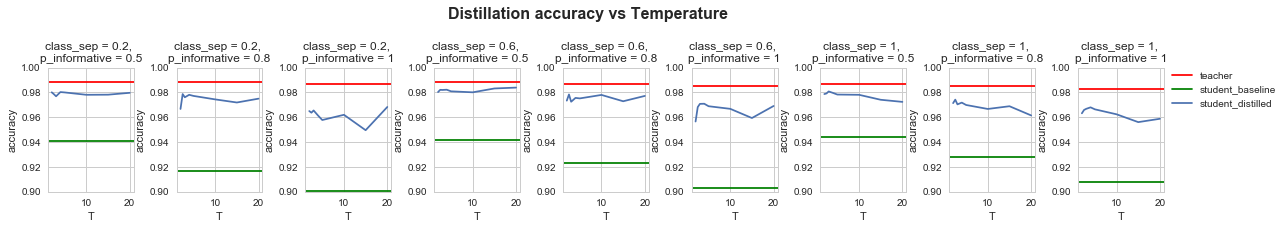

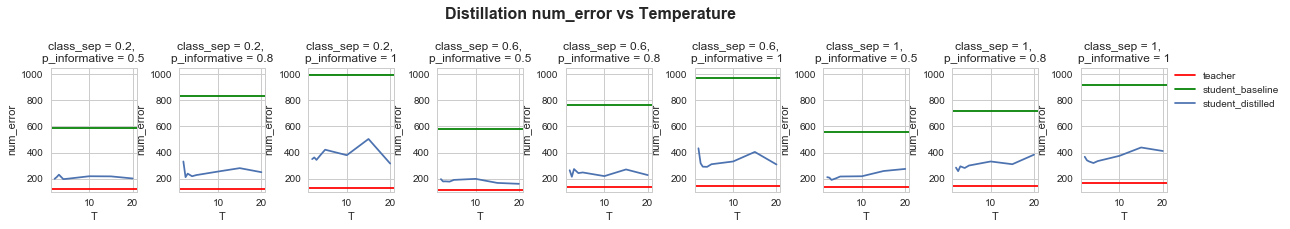

In [42]:
# visualizing results
def viz_result(measure, v_min, v_max):
    l = len(p_informative_list)
    fig, ax = plt.subplots(1, 9, figsize=(20, 3))
    plt.suptitle('Distillation {} vs Temperature'.format(measure), fontsize=16, weight='heavy')
    plt.subplots_adjust(top=0.7, hspace=0.5, wspace=0.5)

    for i, cs in enumerate(class_sep_list):
        for j, pi in enumerate(p_informative_list):
            ax[j+i*l].axhline(results_df.loc[(cs, pi, 'teacher'), measure].values[0], c='r', label='teacher')
            ax[j+i*l].axhline(results_df.loc[(cs, pi, 'student'), measure].values[0], c='g', label='student_baseline')
            ax[j+i*l].plot(results_df.loc[(cs, pi, 'distilled_student'), 'temp'].values, 
                           results_df.loc[(cs, pi, 'distilled_student'), measure].values, label='student_distilled')
            ax[j+i*l].set_xlabel('T')
            ax[j+i*l].set_ylabel(measure)
            ax[j+i*l].set_ylim(v_min, v_max)
            ax[j+i*l].set_title('class_sep = {}, \np_informative = {}'.format(cs, pi))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

viz_result('accuracy', 0.9, 1)
viz_result('num_error', 100, 1050)

### Conclusion - Distillation Results on Fake Datasets

We found that, while distilled student nets showed superior model performance over non-distilled student nets in all cases, data quality did not affect the optimal distillation temperature ($T_{opt} \in (2.5, 5)$ in all cases). Based on the results reported in the paper: A $T_{opt}$ at 20, 8 and 2.5-4 was found for student nets with 800, 300 and 30 nodes per hidden layer, respectively, we suspect that optimal distillation temperature may be more correlated with student net's architecture complexity, where $T_{opt}$ is higher for more complex structures. This hypothesis remains to be tested. 